In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

import plotly
import plotly.plotly as py
from plotly import tools
import re
import swifter


import operator
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

from tqdm import tqdm
tqdm.pandas(desc="Progress")

import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='srjit', api_key='q9HR2PiI8XA1Tdh1Vrr0')

In [7]:
data = pd.read_csv("Lily.csv", delimiter=";")
data_ = data[["Date2","Time","UserName","MessageBody"]]

__Total number of messages__

In [8]:
len(data_)

59228

_About 60k messages in 10 months! Not bad!_

__How many messages have we sent to each other?__

In [9]:
data.groupby("UserName").size().reset_index(name="count")

,UserName,count
0,Lily,25248
1,demiurge 🦇,33980


__What is the average number of messages a person sends the other a day?__

In [10]:
data_grouped_by_day = data.groupby("Date2").size().reset_index(name="count")
data["date_"] = data.apply(lambda x: x["Date2"] + " " + x["Time"], axis=1)
data["date"] = pd.to_datetime(data["date_"])
data["week"] = data["date"].dt.week
data["month"] = data["date"].dt.month
data['day_of_week'] = data['date'].dt.weekday_name

data_grouped_by_day_of_week = data.groupby("day_of_week").size().reset_index(name="count")
data_grouped_by_week = data.groupby("week").size().reset_index(name="count")
data_grouped_by_month = data.groupby("month").size().reset_index(name="count")

__Which days do we talk most on whatsapp?__

Text(0.5, 1.0, 'Count of Messages (weekday)')

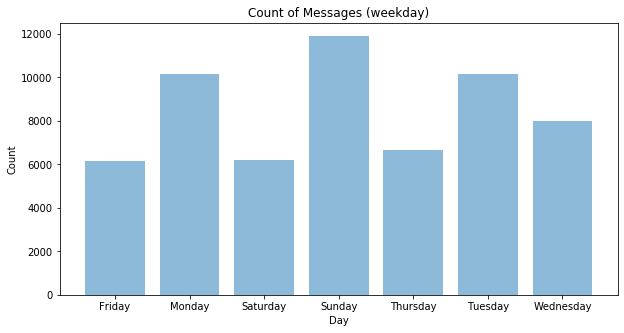

In [11]:
f, ax1 = plt.subplots(1, 1, figsize=(10,5), sharey=True)

ax1.bar(data_grouped_by_day_of_week["day_of_week"], data_grouped_by_day_of_week["count"], alpha=0.5)
ax1.set_xlabel('Day')
ax1.set_ylabel('Count')
ax1.set_title('Count of Messages (weekday)')

_That makes sense. She works on Sundays but not on Saturdays!_

Text(0.5, 1.0, 'Count of Messages per Month')

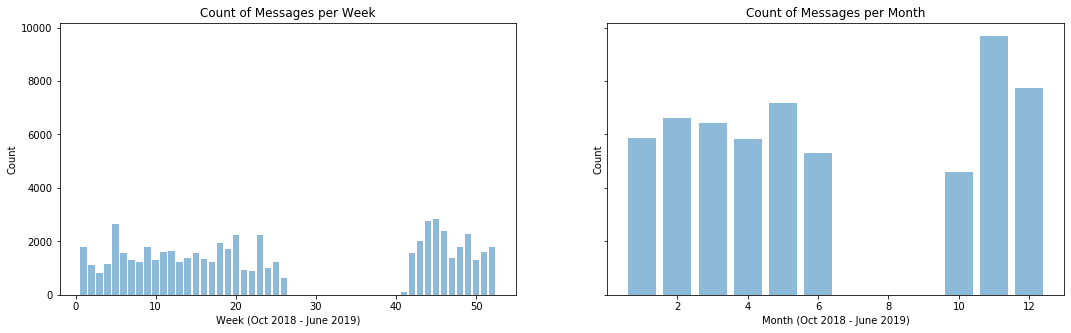

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5), sharey=True)

ax1.bar(data_grouped_by_week["week"], data_grouped_by_week["count"], alpha=0.5)
ax1.set_xlabel('Week (Oct 2018 - June 2019)')
ax1.set_ylabel('Count')
ax1.set_title('Count of Messages per Week')

ax2.bar(data_grouped_by_month["month"], data_grouped_by_month["count"], alpha=0.5)
ax2.set_xlabel('Month (Oct 2018 - June 2019)')
ax2.set_ylabel('Count')
ax2.set_title('Count of Messages per Month')

In [13]:
data_grouped_by_day = data.groupby(["UserName","Date2"]).size().reset_index(name="count")
sree = data_grouped_by_day[data_grouped_by_day.UserName != 'Lily']
lily = data_grouped_by_day[data_grouped_by_day.UserName == 'Lily']

__Daily Message Count Chart__

In [14]:
trace0 = go.Scatter(
    x = sree["Date2"],
    y = sree["count"],
    mode = 'lines',
    name = 'Sree'
)

trace1 = go.Scatter(
    x = lily["Date2"],
    y = lily["count"],
    mode = 'lines',
    name = 'Lia'
)

layout = dict(title = 'Daily Message Chart',
              xaxis = dict(title = 'Day'),
              yaxis = dict(title = 'Count'),
              )


data0 = [trace0, trace1]

fig1 = dict(data=data0, layout=layout)
py.iplot(fig1, filename='daily-line')

Dates with less number of conversations correspond to the ones we spent together!

Most active days: 
    - Jun 4, 2019
    - Nov 10, 2018

Consecutive days where messages are close to zero:
    - Dec 14 / Dec 15 - NY Trip
    - Apr 24/ Apr 25/ Apr 26 - Cali Trip
    - May 25 / May 26 - Maine Trip

## Message Analysis

In [15]:
def cleanup(line):
    word_list = line.lower().split()    
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    cleaned_text = " ".join(filtered_words)
    return cleaned_text

sree = data_[data_.UserName != 'Lily']
lily = data_[data_.UserName == 'Lily']

sree["text"] = sree["MessageBody"].progress_apply(lambda x: cleanup(x))
lily["text"] = lily["MessageBody"].progress_apply(lambda x: cleanup(x))

Progress: 100%|██████████| 25248/25248 [00:22<00:00, 1143.37it/s]


In [16]:
text_s = sree.text.str.cat(sep=" ")
text_l = lily.text.str.cat(sep=" ")

__Most common words in our chats__

In [17]:
def plot(text=text_s, ax=None, title="", xlabel="", ylabel="", dist=None, **kwargs):
    
    wordcloud1 = WordCloud(max_font_size=60).generate(text)
    ax = ax
    ax.axis("off")
    ax.set_title(title)
    return ax.imshow(wordcloud1, interpolation="bilinear")

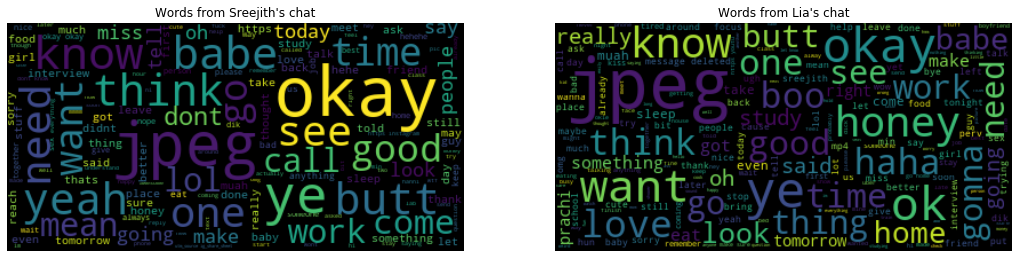

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,10), sharey=True)

plot(text=text_s, ax=ax1, title="Words from Sreejith's chat")
plot(text=text_l, ax=ax2, title="Words from Lia's chat")

__Who said "I love you" first?__

In [19]:
sree["date"] = pd.to_datetime(sree["Date2"])
lily["date"] = pd.to_datetime(lily["Date2"])

sree["lc"] = sree["text"].apply(lambda x: x.count("love you"))
lily["lc"] = lily["text"].apply(lambda x: x.count("love you"))

sree_tmp = sree.groupby("date")['lc'].sum().reset_index(name="count")
lily_tmp = lily.groupby("date")['lc'].sum().reset_index(name="count")

In [20]:
trace3 = go.Scatter(
    x = sree_tmp["date"],
    y = sree_tmp["count"],
    mode = 'lines',
    name = 'Sree'
)

trace4 = go.Scatter(
    x = lily_tmp["date"],
    y = lily_tmp["count"],
    mode = 'lines',
    name = 'Lia'
)

layout = dict(xaxis = dict(title = 'Day'),
              yaxis = dict(title = 'Count'),
              title = "The `I love you` Chart!"
              )


data2 = [trace3, trace4]

fig2 = dict(data=data2, layout=layout)
py.iplot(fig2, filename='foo')

_We said the l-word first after last year's thanksgiving!_  

__What are our top favorite smilies?__

In [21]:
import emoji

def extract_emojis(str_):
    return ''.join(c for c in str_ if c in emoji.UNICODE_EMOJI)

In [22]:
emojis_s = extract_emojis(text_s)
emojis_l = extract_emojis(text_l)
len(emojis_s), len(emojis_l)

(14124, 4602)

_Damn! I use wayyy more emojis_

In [23]:
emoji_counts_s = dict(Counter(emojis_s))
emoji_sorted_s = sorted(emoji_counts_s.items(), key=operator.itemgetter(1), reverse=True)
emoji_fav_s = [emoji for (emoji, count) in emoji_sorted_s]

emoji_counts_l = dict(Counter(emojis_l))
emoji_sorted_l = sorted(emoji_counts_l.items(), key=operator.itemgetter(1), reverse=True)
emoji_fav_l = [emoji for (emoji, count) in emoji_sorted_l]

__Sreejith's favorite smilies__

In [24]:
emoji_fav_s[:15]

['😘', '😂', '🙈', '🍑', '🌑', '😍', '😬', '♀', '😭', '♂', '😒', '❤', '😉', '😋', '🧝']

__Lia's favorite smilies__

In [25]:
emoji_fav_l[:15]

['😊', '😒', '😘', '😂', '😍', '😚', '🥰', '😩', '❤', '😭', '😏', '😝', '😗', '😳', '💋']

__Analysis of Emotion in our Chats__

In [26]:
analyser = SentimentIntensityAnalyzer()


def get_sentiment2(text):
    scores = analyser.polarity_scores(text) 
    sentiment = None
    if scores['neg'] > scores['pos']:
        if scores['neg'] > scores['neu']:
            sentiment = 'neg'
        else:
            sentiment = 'neu'
    else:
        if scores['pos'] > scores['neu']:
            sentiment = 'pos'
        else:
            sentiment = 'neu'
    return (sentiment, scores['compound'])

In [27]:
sree["sentiment_all"] = sree["MessageBody"].progress_apply(lambda x: get_sentiment2(x))
lily["sentiment_all"] = lily["MessageBody"].progress_apply(lambda x: get_sentiment2(x))

sree["sentiment"] = sree["sentiment_all"].progress_apply(lambda x: x[0])
sree["sentiment_score"] = sree["sentiment_all"].progress_apply(lambda x: x[1])
lily["sentiment"] = lily["sentiment_all"].progress_apply(lambda x: x[0])
lily["sentiment_score"] = lily["sentiment_all"].progress_apply(lambda x: x[1])

Progress: 100%|██████████| 25248/25248 [00:00<00:00, 362753.10it/s]


In [28]:
sree["date_"] = sree.apply(lambda x: x["Date2"] + " " + x["Time"], axis=1)
sree["full_date"] = pd.to_datetime(sree["date_"])
sree["hour"] = sree.full_date.dt.hour

lily["date_"] = lily.apply(lambda x: x["Date2"] + " " + x["Time"], axis=1)
lily["full_date"] = pd.to_datetime(lily["date_"])
lily["hour"] = lily.full_date.dt.hour

# Group by date and hour and get a combined `compound` score
sree_day_hour_grouped = sree.groupby(['Date2','hour'])['sentiment_score'].mean().reset_index(name="score")
lily_day_hour_grouped = lily.groupby(['Date2','hour'])['sentiment_score'].mean().reset_index(name="score")

In [29]:
data2 = [
    go.Heatmap(
        z=sree_day_hour_grouped['score'],
        x=sree_day_hour_grouped['Date2'],
        y=sree_day_hour_grouped['hour'],
        colorscale='Jet',
    )
]

layout2 = go.Layout(
    title="Sreejith's Mean Hourly Message Sentiment",
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' )
)

fig4 = go.Figure(data=data2, layout=layout2)
py.iplot(fig4, filename='datetime-heatmap')


# Red is Positive Sentiment
# Green is Neutral Sentiment
# Blue end is Negative Sentiment

In [30]:
data3 = [
    go.Heatmap(
        z=lily_day_hour_grouped['score'],
        x=lily_day_hour_grouped['Date2'],
        y=lily_day_hour_grouped['hour'],
        colorscale='Jet',
    )
]

layout3 = go.Layout(
    title="Lia's Mean Hourly Message Sentiment",
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' )
)

fig5 = go.Figure(data=data3, layout=layout3)
py.iplot(fig5, filename='datetime-heatmap')

_There is no data after between 1am and 7am (Sleep time)_

In [31]:
lily[(lily.Date2 == "2018-12-18") & (lily.sentiment_score > 0) & (lily.sentiment == 'pos')][:5]

,Date2,Time,UserName,MessageBody,text,date,lc,sentiment_all,sentiment,sentiment_score,date_,full_date,hour
19017,2018-12-18,05:13:12,Lily,I love you 💖💕,love 💖💕,2018-12-18,0,"(pos, 0.6369)",pos,0.6369,2018-12-18 05:13:12,2018-12-18 05:13:12,5
19024,2018-12-18,08:51:38,Lily,So cute!!,cute!!,2018-12-18,0,"(pos, 0.5963)",pos,0.5963,2018-12-18 08:51:38,2018-12-18 08:51:38,8
19036,2018-12-18,08:53:56,Lily,Haha,haha,2018-12-18,0,"(pos, 0.4588)",pos,0.4588,2018-12-18 08:53:56,2018-12-18 08:53:56,8
19043,2018-12-18,08:59:11,Lily,:),:),2018-12-18,0,"(pos, 0.4588)",pos,0.4588,2018-12-18 08:59:11,2018-12-18 08:59:11,8
19064,2018-12-18,09:05:17,Lily,Ok,ok,2018-12-18,0,"(pos, 0.296)",pos,0.2960,2018-12-18 09:05:17,2018-12-18 09:05:17,9


Note: This classifier does not do a good job at classifying negative emotions. 
      Replace it with one of the DNN implementations here : https://github.com/SenticNet/conv-emotion

In [32]:
sree_neg = sree[sree.sentiment == "neg"]
lily_neg = lily[lily.sentiment == "neg"]

sree_pos = sree[sree.sentiment == "pos"]
lily_pos = lily[lily.sentiment == "pos"]

sree_neu = sree[sree.sentiment == "neu"]
lily_neu = lily[lily.sentiment == "neu"]


sree_neg_grouped_by_day = sree_neg.groupby(["date"]).size().reset_index(name="count")
lily_neg_grouped_by_day = lily_neg.groupby(["date"]).size().reset_index(name="count")

sree_pos_grouped_by_day = sree_pos.groupby(["date"]).size().reset_index(name="count")
lily_pos_grouped_by_day = lily_pos.groupby(["date"]).size().reset_index(name="count")

sree_neu_grouped_by_day = sree_neu.groupby(["date"]).size().reset_index(name="count")
lily_neu_grouped_by_day = lily_neu.groupby(["date"]).size().reset_index(name="count")

In [33]:
len(sree_neg), len(lily_neg), len(sree_neg_grouped_by_day), len(lily_neg_grouped_by_day)

(1764, 1629, 229, 227)

In [34]:
len(sree_pos), len(lily_pos), len(sree_pos_grouped_by_day), len(lily_pos_grouped_by_day)

(6106, 4352, 238, 234)

_Count of positive messages are more (good lol!). Wonder how good the sentiment classifier is!_

In [35]:
sree_neg.head()

,Date2,Time,UserName,MessageBody,text,date,lc,sentiment_all,sentiment,sentiment_score,date_,full_date,hour
38,2018-10-14,13:27:05,demiurge 🦇,Stop saying that,stop saying,2018-10-14,0,"(neg, -0.296)",neg,-0.2960,2018-10-14 13:27:05,2018-10-14 13:27:05,13
138,2018-10-15,13:42:03,demiurge 🦇,Annoying you,annoying,2018-10-15,0,"(neg, -0.4019)",neg,-0.4019,2018-10-15 13:42:03,2018-10-15 13:42:03,13
175,2018-10-15,14:49:51,demiurge 🦇,seriously ?,seriously ?,2018-10-15,0,"(neg, -0.1779)",neg,-0.1779,2018-10-15 14:49:51,2018-10-15 14:49:51,14
423,2018-10-16,18:16:04,demiurge 🦇,Crushed rice,crushed rice,2018-10-16,0,"(neg, -0.4215)",neg,-0.4215,2018-10-16 18:16:04,2018-10-16 18:16:04,18
449,2018-10-16,18:21:09,demiurge 🦇,i'm sorry,i'm sorry,2018-10-16,0,"(neg, -0.0772)",neg,-0.0772,2018-10-16 18:21:09,2018-10-16 18:21:09,18


_Damn! Thats a pretty bad emotion classifier_

In [36]:
len(sree_neu), len(lily_neu), len(sree_neu_grouped_by_day), len(lily_neu_grouped_by_day)

(26110, 19267, 248, 247)

__What places do we talk about in our conversations?__

In [47]:
# st = StanfordNERTagger('/Users/lia/Downloads/stanford-ner-2018-10-16/classifiers/english.all.3class.distsim.crf.ser.gz',
#                        '/Users/lia/Downloads/stanford-ner-2018-10-16/stanford-ner.jar',
#                         encoding='utf-8')

# def get_loc_from_ner(text):
    
#     tokenized_text = word_tokenize(text)
#     classified_text = st.tag(tokenized_text)
    
#     return [entity for (entity, type_) in classified_text if type_ == 'LOCATION']


from sner import Ner


def get_ner_from_server(text):
    tagger = Ner(host='localhost',port=9199)
    classified_text = tagger.get_entities(text)
    return [entity for (entity, type_) in classified_text if type_ == 'LOCATION']


In [51]:
tmp = sree.head(20)
tmp["locations"] = tmp["text"].swifter.apply(lambda x: get_loc_from_ner(x))

In [46]:
tmp.head()

,Date2,Time,UserName,MessageBody,text,date,lc,sentiment_all,sentiment,sentiment_score,date_,full_date,hour,locations
0,2018-10-14,13:13:09,demiurge 🦇,😍😍,😍😍,2018-10-14,0,"(neu, 0.0)",neu,0.0,2018-10-14 13:13:09,2018-10-14 13:13:09,13,[]
2,2018-10-14,13:19:43,demiurge 🦇,Yaaay,yaaay,2018-10-14,0,"(neu, 0.0)",neu,0.0,2018-10-14 13:19:43,2018-10-14 13:19:43,13,[]
3,2018-10-14,13:19:51,demiurge 🦇,Finally she is on whatsapp,finally whatsapp,2018-10-14,0,"(neu, 0.0)",neu,0.0,2018-10-14 13:19:51,2018-10-14 13:19:51,13,[]
4,2018-10-14,13:19:54,demiurge 🦇,😍😍,😍😍,2018-10-14,0,"(neu, 0.0)",neu,0.0,2018-10-14 13:19:54,2018-10-14 13:19:54,13,[]
8,2018-10-14,13:20:46,demiurge 🦇,Hehehe 😬. They're.,hehehe 😬. they're.,2018-10-14,0,"(neu, 0.0)",neu,0.0,2018-10-14 13:20:46,2018-10-14 13:20:46,13,[]


In [34]:
# Vectorization

# vectorizer_s = CountVectorizer()
# vectorized_words_s = vectorizer_s.fit_transform(sree.text)

# count_vocab_s = {value:key for key,value in vectorizer_s.vocabulary_.items()}
# count_rev_dict_s = {value:key for key,value in vectorizer_s.vocabulary_.items()}
# words_s = [count_rev_dict_s[i] for i in range(len(vectorizer_s.vocabulary_.keys()))]

# term_frequency_s = vectorized_words_s.sum(axis=0).reshape(-1,).tolist()[0]
# tf_with_index_s = {words_s[idx]: term for idx, term in enumerate(term_frequency_s)}

# sum_tf_s = sum(term_frequency_s)
# tf_sorted_s = sorted(tf_with_index_s.items(), key=operator.itemgetter(1), reverse=True)

# word_tf_percent_s = [(tmp[0], round(tmp[1]/sum_tf_s, 3)) for tmp in tf_sorted_s]